In [30]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # 下面老是报错 shape 不一致
os.environ['TORCH_USE_CUDA_DSA'] = '1'

#### 加载数据集

In [2]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载数据集
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [3]:
print(train_dataset[0][0].shape)
print(train_loader)

torch.Size([1, 28, 28])


#### 双向LSTM模型

In [4]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # bidirectional=True表示使用双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 双向LSTM输出为hidden_size * 2
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)  # 初始化隐藏状态
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)  # 初始化cell状态
        
        out, _ = self.lstm(x, (h0, c0))  # LSTM输出
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出作为预测
        return out

#### 超参数

In [5]:
input_size = 28  # MNIST图像宽度
sequence_length = 28  # MNIST图像高度
num_classes = 10  # 数字类别数
hidden_size = 128  # 隐藏层大小
num_layers = 2  # LSTM层数
dropout = 0.2  # Dropout概率
batch_size = 100  # 批次大小
num_epochs = 5  # 迭代次数
learning_rate = 0.001  # 学习率

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = BiLSTM(input_size, hidden_size, num_layers, num_classes, dropout).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


#### 训练函数

In [25]:
def train(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    process_bar = tqdm(train_loader, desc=f'Training', unit="batch", leave=True)
    for i, (images, labels) in enumerate(process_bar):
        images = images.squeeze(1).to(device)  # 去除通道维度
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
        
        # 更新进度条,进度条显示acc=..., loss=...(=前的相同,后面的不断更新计算)
        process_bar.set_postfix(loss=running_loss/total, acc=float(running_corrects.double()/total))
    return running_loss/total, float(running_corrects.double()/total)

#### 测试函数

In [28]:
def test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        tqdm_test = tqdm(test_loader, desc='Testing', leave=True)
        for images, labels in tqdm_test:
            images = images.squeeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        return acc

In [29]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_acc = test(model, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")

Testing: 100%|██████████| 79/79 [00:01<00:00, 62.89it/s]


Epoch 1, Train Loss: 0.0097, Train Acc: 1.00, Test Acc: 0.99


Testing: 100%|██████████| 79/79 [00:01<00:00, 60.81it/s]


Epoch 2, Train Loss: 0.0107, Train Acc: 1.00, Test Acc: 0.99


Testing: 100%|██████████| 79/79 [00:01<00:00, 60.99it/s]


Epoch 3, Train Loss: 0.0091, Train Acc: 1.00, Test Acc: 0.99


Testing: 100%|██████████| 79/79 [00:01<00:00, 61.62it/s]


Epoch 4, Train Loss: 0.0046, Train Acc: 1.00, Test Acc: 0.99


Testing: 100%|██████████| 79/79 [00:01<00:00, 64.38it/s]

Epoch 5, Train Loss: 0.0085, Train Acc: 1.00, Test Acc: 0.99


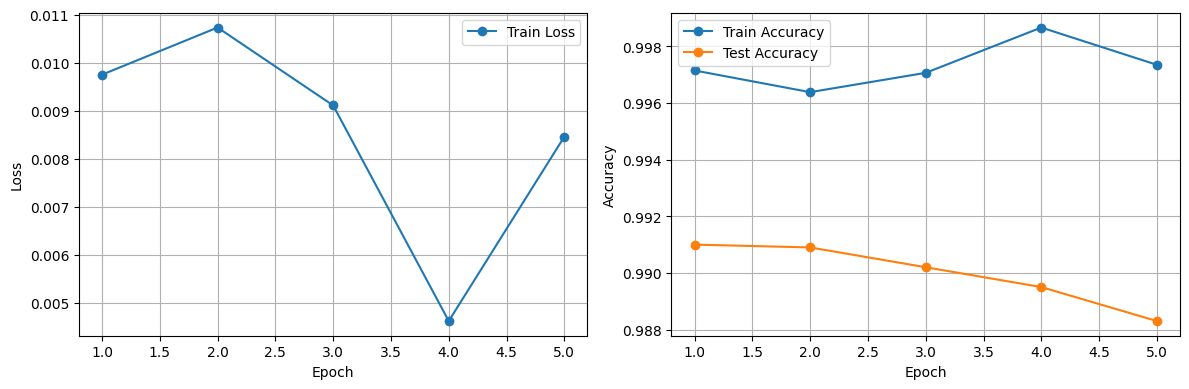

In [31]:
def show_plot():
    # 绘制训练损失和准确率
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker = 'o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker = 'o')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker = 'o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()

    plt.show()

show_plot()